## Config

In [1]:
# env
DEVICE = "cuda"
DATA_PATH = "data"

# train
BATCH_SIZE = 512
EPOCHS = 5
LR = 5e-5

## Load pretrained model

In [2]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.to(DEVICE)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", clean_up_tokenization_spaces=False)

/data3/nlpuos/miniconda3/envs/ycson-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data3/nlpuos/miniconda3/envs/ycson-env/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Setup Dataset

In [16]:
import torch, torchvision

class CIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, clip_processor, is_train):
        self.clip_processor = clip_processor
        self.is_train = is_train
        self.dataset = torchvision.datasets.CIFAR10(DATA_PATH, train=is_train)
        self.class_texts = [
            f"A photo of a {class_}."
            for class_ in self.dataset.class_to_idx.keys()
        ]
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        text = self.class_texts[label]
        return {
            "image": image,
            "label": label,
            "text": text,
        }
    
    # batch로 데이터 전처리
    def preprocess(self, batch):
        images = [data["image"] for data in batch]
        labels = [data["label"] for data in batch]
        texts = [data["text"] for data in batch]

        inputs = self.clip_processor(
            text=texts,
            images=images,
            return_tensors="pt", 
            padding=True
        )
        
        return {
            "text": texts,
            "label": torch.tensor(labels),
            **inputs,
        }

train_dataset = CIFAR10Dataset(processor, is_train=True)
test_dataset = CIFAR10Dataset(processor, is_train=False)

train_dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=train_dataset.preprocess, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, collate_fn=train_dataset.preprocess, batch_size=BATCH_SIZE)

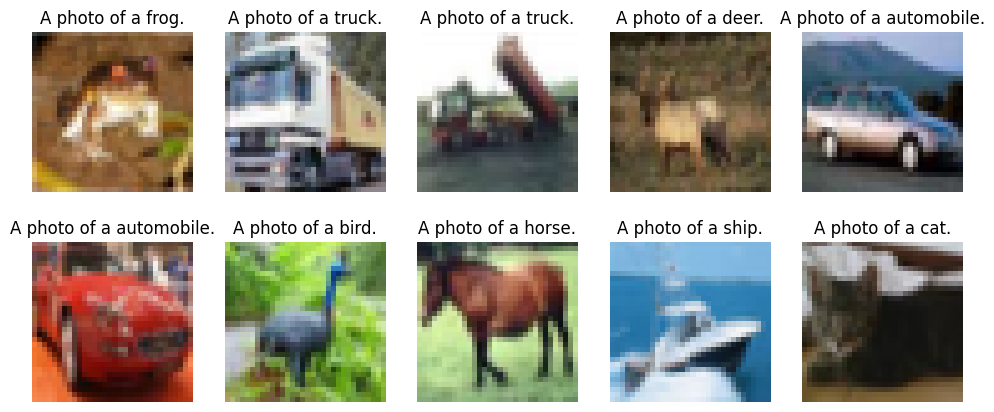

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

for i, data in enumerate(train_dataset):
    plt.subplot(2,5,i+1)
    plt.imshow(data["image"])
    plt.title(data["text"])
    plt.axis("off")
    
    if i == 9:
        break

## Fine-tune model

In [5]:
import torch.nn.functional as F

def loss_fn(logits_per_image, logits_per_text):
    assert logits_per_image.shape[0] == logits_per_image.shape[0] # logits' shape should be (nxn)
    assert logits_per_image.shape == logits_per_text.shape
    
    labels = torch.arange(logits_per_image.shape[0], device=DEVICE)
    loss_i = F.cross_entropy(logits_per_image, labels)
    loss_t = F.cross_entropy(logits_per_image, labels)
    loss = (loss_i + loss_t) / 2
    
    return loss

In [6]:
from torch.optim import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=LR)
model.train()

for epoch in tqdm(range(1, EPOCHS+1), position=0, desc="epoch"):
    for batch in tqdm(train_dataloader, position=0, desc="batch", leave=False):
        optimizer.zero_grad()

        outputs = model(
            pixel_values=batch["pixel_values"].to(DEVICE),
            input_ids=batch["input_ids"].to(DEVICE),
            attention_mask=batch["attention_mask"].to(DEVICE),
        )

        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text # logits_per_text == logits_per_image.T
        loss = loss_fn(logits_per_image, logits_per_text)
        loss.backward()
                
        optimizer.step()

    print(f"Train loss: {loss}")

epoch:  20%|██        | 1/5 [04:41<18:45, 281.41s/it] 

Train loss: 5.051612377166748


epoch:  40%|████      | 2/5 [08:28<12:27, 249.22s/it] 

Train loss: 3.6610732078552246


epoch:  60%|██████    | 3/5 [12:12<07:56, 238.07s/it] 

Train loss: 3.641077756881714


epoch:  80%|████████  | 4/5 [15:58<03:53, 233.10s/it] 

Train loss: 3.573212146759033


epoch: 100%|██████████| 5/5 [19:46<00:00, 237.21s/it] 

Train loss: 3.5555057525634766


## Evaluate

In [18]:
import torch.nn.functional as F

all_class_texts = processor.tokenizer(test_dataset.class_texts)
all_class_texts = {k: torch.tensor(v, device=DEVICE) for k, v in all_class_texts.items()}

model.eval()
correct_count = 0
ce_loss_sum = 0

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        outputs = model(
            pixel_values=batch["pixel_values"].to(DEVICE),
            **all_class_texts,
        )
        
        probs = outputs.logits_per_image.cpu().softmax(dim=1)
        pred = probs.argmax(dim=1)
        label = batch["label"]

        correct_count += (pred == label).sum().item()
        ce_loss_sum += F.cross_entropy(probs, label).item()
    
accuracy = correct_count / len(test_dataloader.dataset)
ce_loss = ce_loss_sum / len(test_dataloader)
print(f"Test CE loss: {ce_loss:.4}, Test accuracy: {accuracy:.4}")

100%|██████████| 20/20 [00:45<00:00,  2.27s/it]

Test CE loss: 1.522, Test accuracy: 0.9452
